## Import CNN/Daily Mail Dataset

In [1]:
from datasets import load_dataset
from utils.sample import sample, print_sample
import torch
import os
import random
import numpy as np
from transformers import set_seed

# Seed for reproducability
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
set_seed(seed)

corpus = load_dataset("cnn_dailymail", "3.0.0")
train_corpus = corpus["train"]
test_corpus = corpus["test"]

example = sample(train_corpus)
print_sample(example, max_chars=200)

Article:
"(CNN) -- A magnitude 7.9 earthquake struck off the coast of central Peru on Wednesday evening, killing 15 people and leaving 70 hurt, President Alan Garcia said on national television. Pedestrians tr...

Highlights:
"NEW: Tsunami warnings and watches canceled, as is Hawaii's advisory .\nAt least 15 people killed, 70 injured in quake .\nQuake was felt for two minutes; people ran out of office buildings in panic .\...

Id:
"fca2c956e45391f8b205cbe78e6b454321d49305"



## Compare BART and PEGASUS models

### Select Samples

In [2]:
# Select 100 articles
NUM_SAMPLES = 100
articles = sample(test_corpus, NUM_SAMPLES)

### Import Models

In [3]:
from utils.pipeline import make_bart_pipeline, make_pegasus_pipeline

bart_pipeline = make_bart_pipeline()
pegasus_pipeline = make_pegasus_pipeline()

Device set to use cpu
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu


### Prepare Summarizers

In [4]:
from core.summarizer import Summarizer

model_configs = {
    'bart': Summarizer(bart_pipeline),
    'pegasus': Summarizer(pegasus_pipeline)
}

### Generate & Evaluate Summaries

Evaluating: BART...

Generating summaries for 100 articles...

Completed in 00:11:58.53


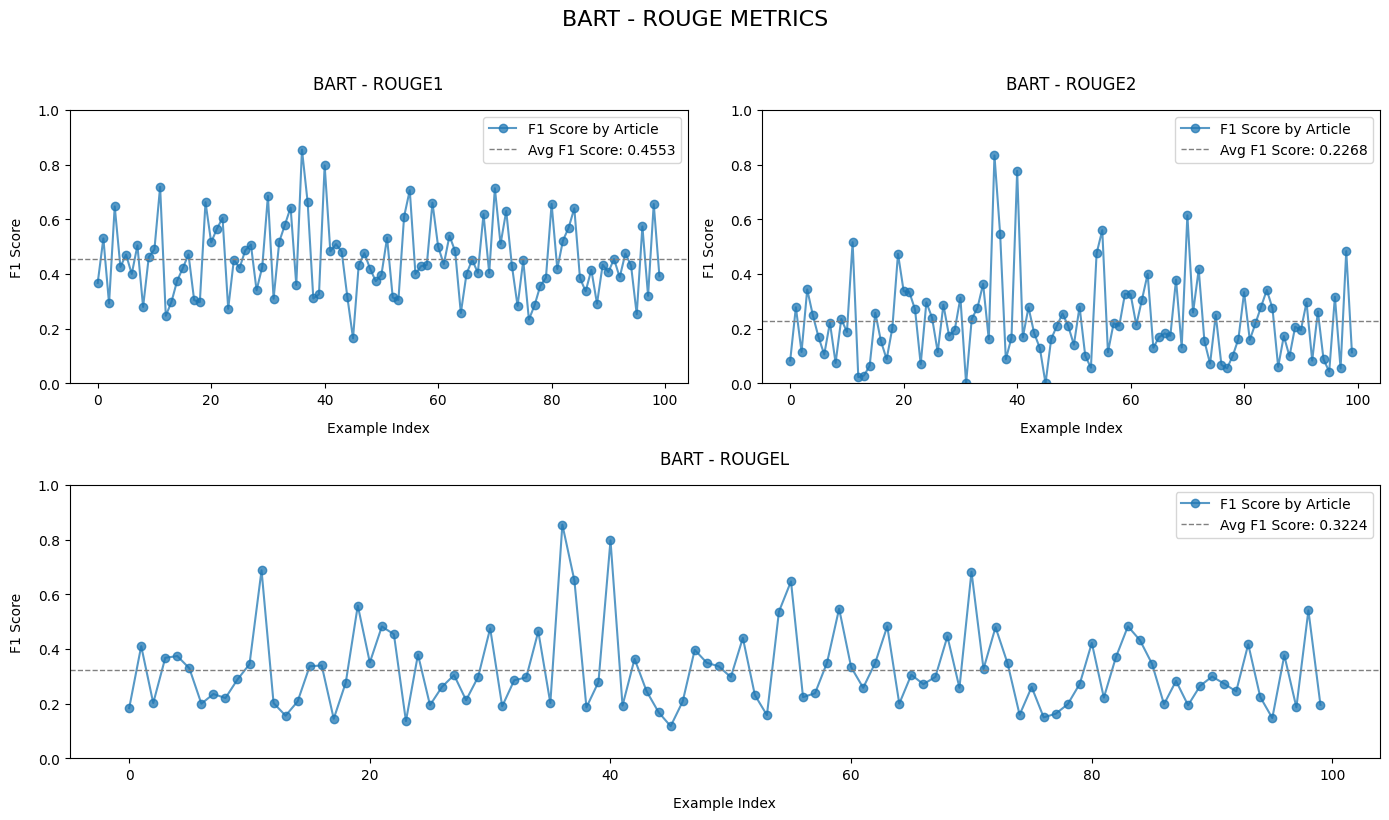

Evaluating: PEGASUS...

Generating summaries for 100 articles...

Completed in 00:16:30.70


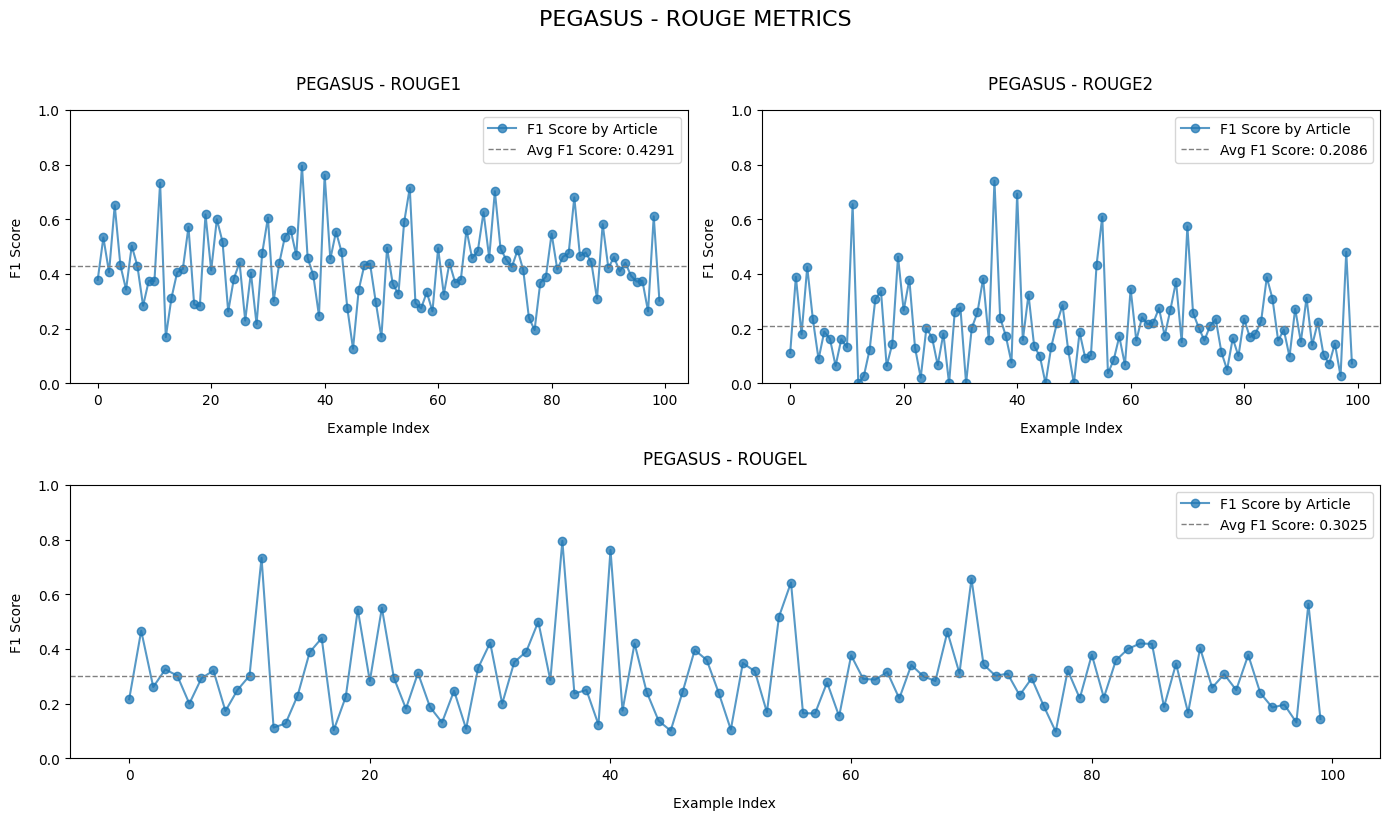

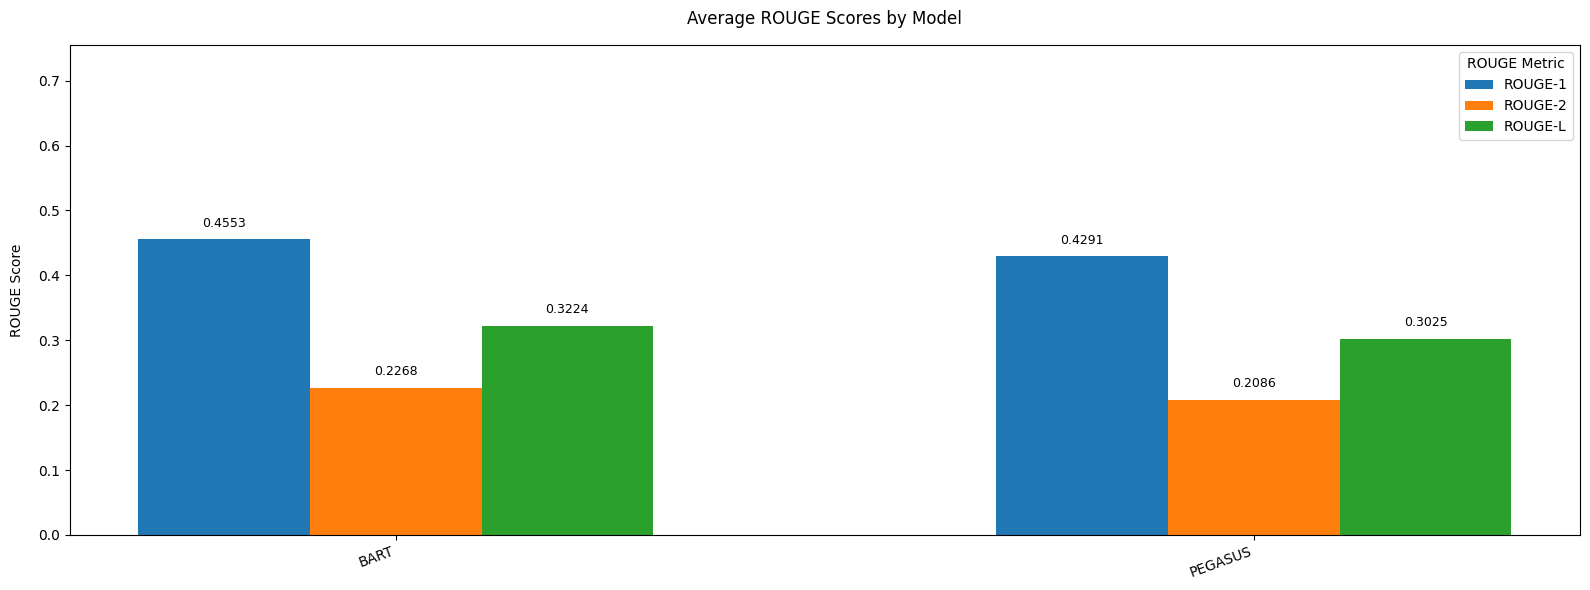

In [5]:
from utils.sum_eval import sum_eval
from utils.plot import plot_avg_rouge, plot_avg_manual_score
import pandas as pd

results_dir = os.path.join("..", "results")
os.makedirs(results_dir, exist_ok=True)

model_scores = sum_eval(articles, model_configs)
df_models = pd.DataFrame(model_scores).T.sort_values(by='rougeL', ascending=False)

plot_avg_rouge(model_scores, save_path=os.path.join(results_dir, 'avg_rouge_scores'))

### Extrinsic Evaluation

In [6]:
# Select 10 articles
NUM_RANDOM_SAMPLES = 10
manual_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

In [7]:
# Generate summaries
bart_summarizer = model_configs['bart']
bart_summaries = bart_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:19.48


##### BART

In [8]:
from evaluation.extrinsic_evaluator import ExtrinsicEvaluator

# Evaluate Bart
bart_evaluator = ExtrinsicEvaluator(bart_summaries)
bart_evaluator.evaluate('BART')
bart_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
bart_evaluator.submit_scores(bart_id_to_score)


Manually evaluating BART...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. I w

##### PEGASUS

In [9]:
# Generate Summaries
pegasus_summarizer = model_configs['pegasus']
pegasus_summaries = pegasus_summarizer.structured_batch_summarize(manual_articles)

Generating summaries for 10 articles...

Completed in 00:01:46.31


In [10]:
# Evaluate PEGASUS
pegasus_evaluator = ExtrinsicEvaluator(pegasus_summaries)
pegasus_evaluator.evaluate('PEGASUS')
pegasus_id_to_score = {
    "432642e19523c71e986985b0a1bb82f6baa9dc4f": 5,
    "15fffd5f6e0249a50b8ff64afa785a56e3cd6329": 5,
    "a4f3403c0c05589f939d0f4ddb138e8e2c5d288e": 5,
    "bc526b7c50b3b816751a6a692cdb7324d980a576": 5,
    "ca5cf6768d5700c8e944d7ec773d2116075d9003": 5,
    "41722a8d14392fd2999bafbcec86f04d5634590f": 5,
    "85afff41a6d8d564588c54c6b5b9ff972dfe0eff": 5,
    "868be1a9da96d8ddbc357599943293a7684eb271": 5,
    "197354baef143a117e28c3d7e6497fe3f08c975f": 5,
    "f9b726faba76c1808f033491ef21960438ce5914": 5,
}
pegasus_evaluator.submit_scores(pegasus_id_to_score)

Manually evaluating PEGASUS...
ID: b02798e17147839d052ead06f9be7674d6ab5a8d
Article:
Following all his inspired charity work, Didier Drogba has been awarded with a Barclays Spirit of the Game trophy. The Chelsea forward set up the 'Didier Drogba Foundation in Africa,' as he hopes to inspire the next generation of footballers in Africa to fall in love with the game. The 37-year-old, who scored against Leicester on Wednesday, spoke in the video about his experiences growing up in the Ivory Coast and his love for football. Didier Drogba with the Barclays Spirit of the Game award following all the charity work he's done in Africa . The Ivorian scored the equaliser for Chelsea against Leicester on Wednesday, his seventh of the season . He said 'I come from a poor family where I played football in the streets with my friends with no shoes, there was no grass but we still enjoyed it. 'There is nothing better than when you see a kid with a smile on his face and that is why I'm trying to help. 

#### Plot Manual Scores

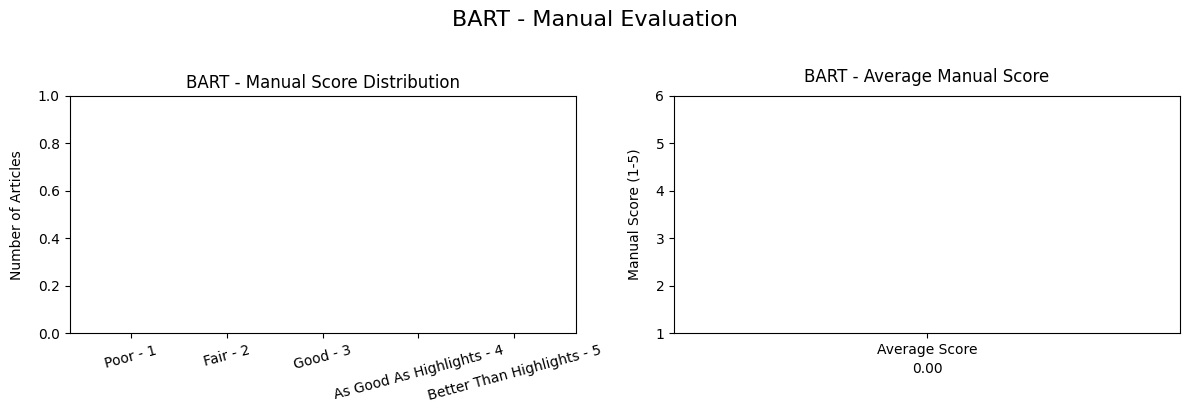

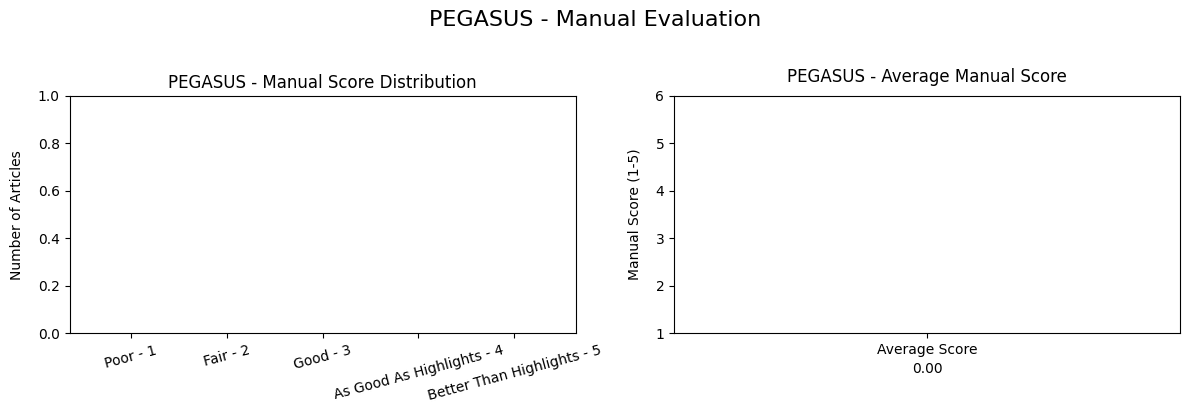

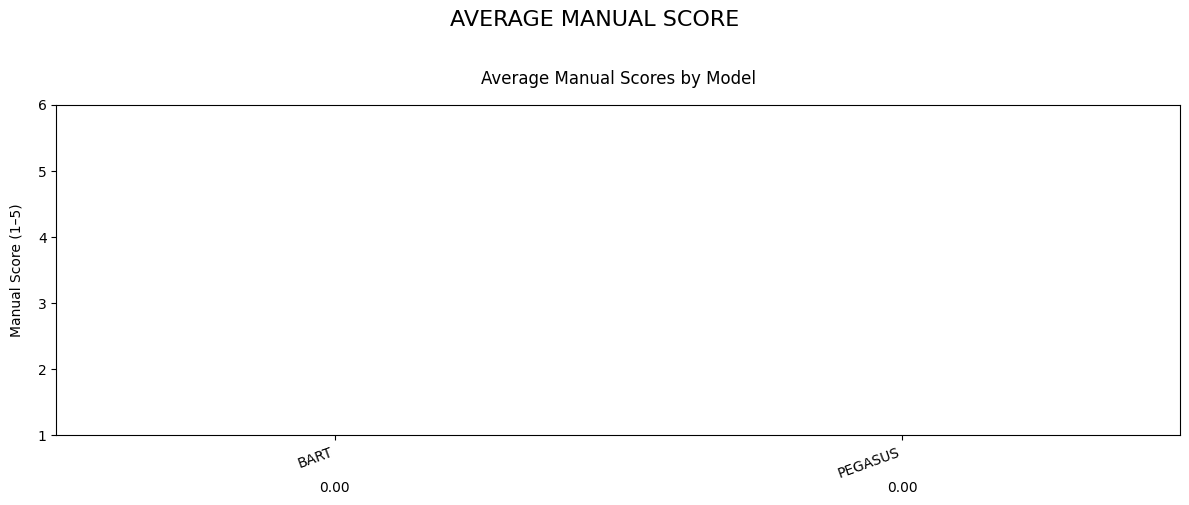

In [11]:
bart_evaluator.plot('BART', save_path=os.path.join(results_dir, 'bart'))
pegasus_evaluator.plot('PEGASUS', save_path=os.path.join(results_dir, 'pegasus'))

avg_manual_scores = {
    'bart': bart_evaluator.avg_score,
    'pegasus': pegasus_evaluator.avg_score
}

plot_avg_manual_score(avg_manual_scores, save_path=os.path.join(results_dir, 'avg_manual_scores'))

#### Winner is BART

## Ablation Study

### Hyperparameter Strategies

In [12]:
from utils.pipeline import make_bart_pipeline

DEFAULT_MIN_LENGTH = 30
DEFAULT_MAX_LENGTH = 100
bart_pipeline = make_bart_pipeline()

ablation_configs = {
    # Baseline
    'bart_default': Summarizer(
        bart_pipeline,
        num_beams=1,  # Cheapest model with default num_beams
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    # Beam search contrast: moderate (4), expensive (16)
    'bart_beam_4': Summarizer(
        bart_pipeline,
        num_beams=4,
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    'bart_beam_16': Summarizer(
        bart_pipeline,
        num_beams=16,
        length_penalty=1.2,      # counteract bias toward shorter sequences
        no_repeat_ngram_size=3,  # prevents repeated tri-gram sequences in a single output
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # Length penalty: shorter (0.8), longer (1.2) 
    'bart_len_pen_08': Summarizer(
        bart_pipeline,
        num_beams=4,
        length_penalty=0.8,  # favor shorter outputs during beam search
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    'bart_len_pen_12': Summarizer(
        bart_pipeline,
        num_beams=4,
        length_penalty=1.2,  # favor longer outputs during beam search
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    
    # No-repetition of tri-grams
    'bart_nr_3gram': Summarizer(
        bart_pipeline,
        num_beams=4,
        no_repeat_ngram_size=3,  # prevents repeated tri-gram sequences in a single output
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),

    # Sampling: low (0.5), high (0.9)
    'bart_sample_lowp': Summarizer(
        bart_pipeline,
        do_sample=True,  # sample instead of greedy
        top_p=0.5,  # keep smallest token set with cumulative prob >= 0.5
        temperature=1.0,
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),
    'bart_sample_highp': Summarizer(
        bart_pipeline,
        do_sample=True,
        top_p=0.9,  # keep larger token set (cum prob >= 0.9) for more variety
        temperature=1.2,  # slightly flatten distro to give lower probs tokens more chance 
        min_length=DEFAULT_MIN_LENGTH,
        max_length=DEFAULT_MAX_LENGTH
    ),

    # Shorter summaries
    'bart_short': Summarizer(
        bart_pipeline,
        min_length=20,
        max_length=60
    ),
}

Device set to use cpu


### Prepare Summarizers

### Generate & Evaluate Summaries

The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Evaluating: BART_DEFAULT...

Generating summaries for 100 articles...



The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['ear

Completed in 00:03:32.68


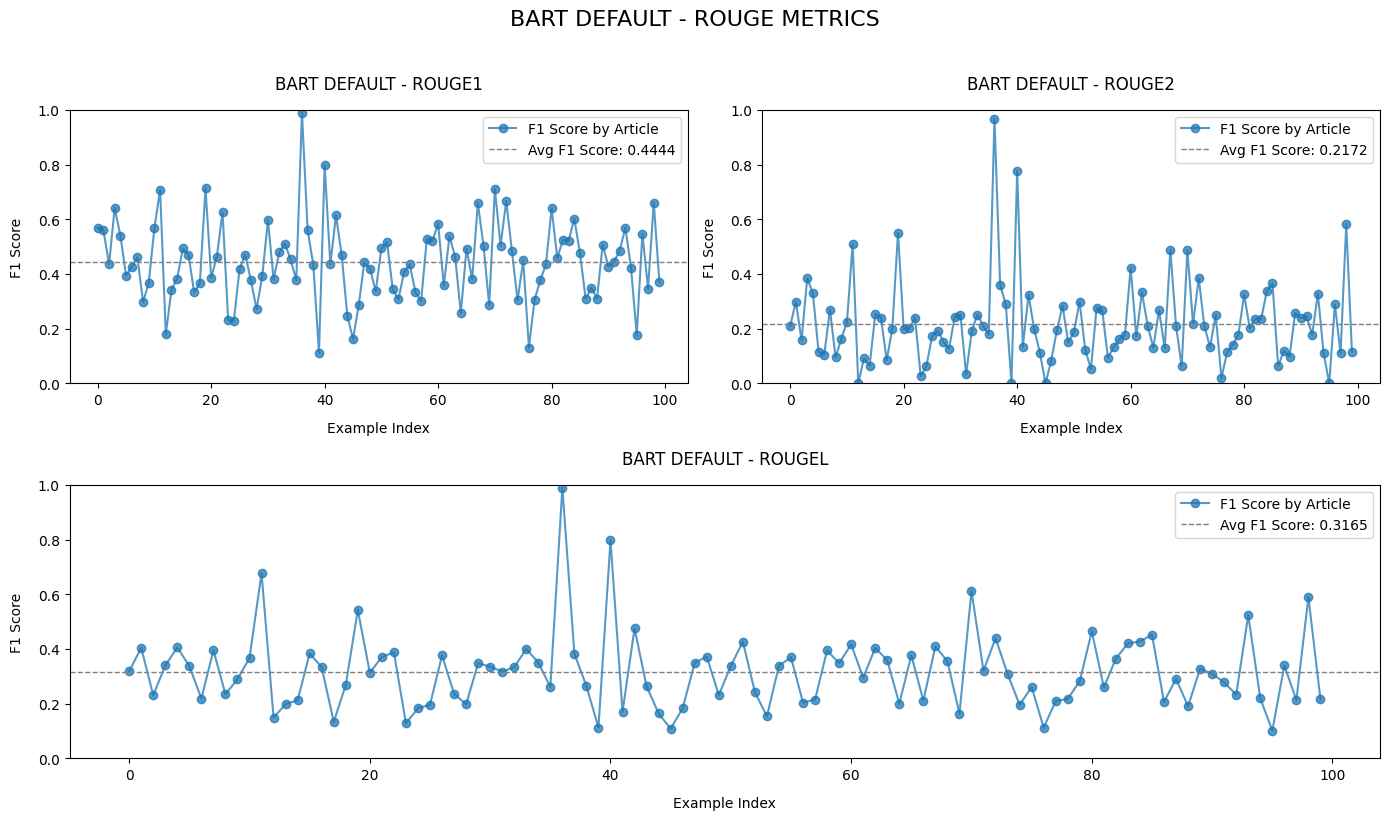

Evaluating: BART_BEAM_4...

Generating summaries for 100 articles...

Completed in 00:11:8.13


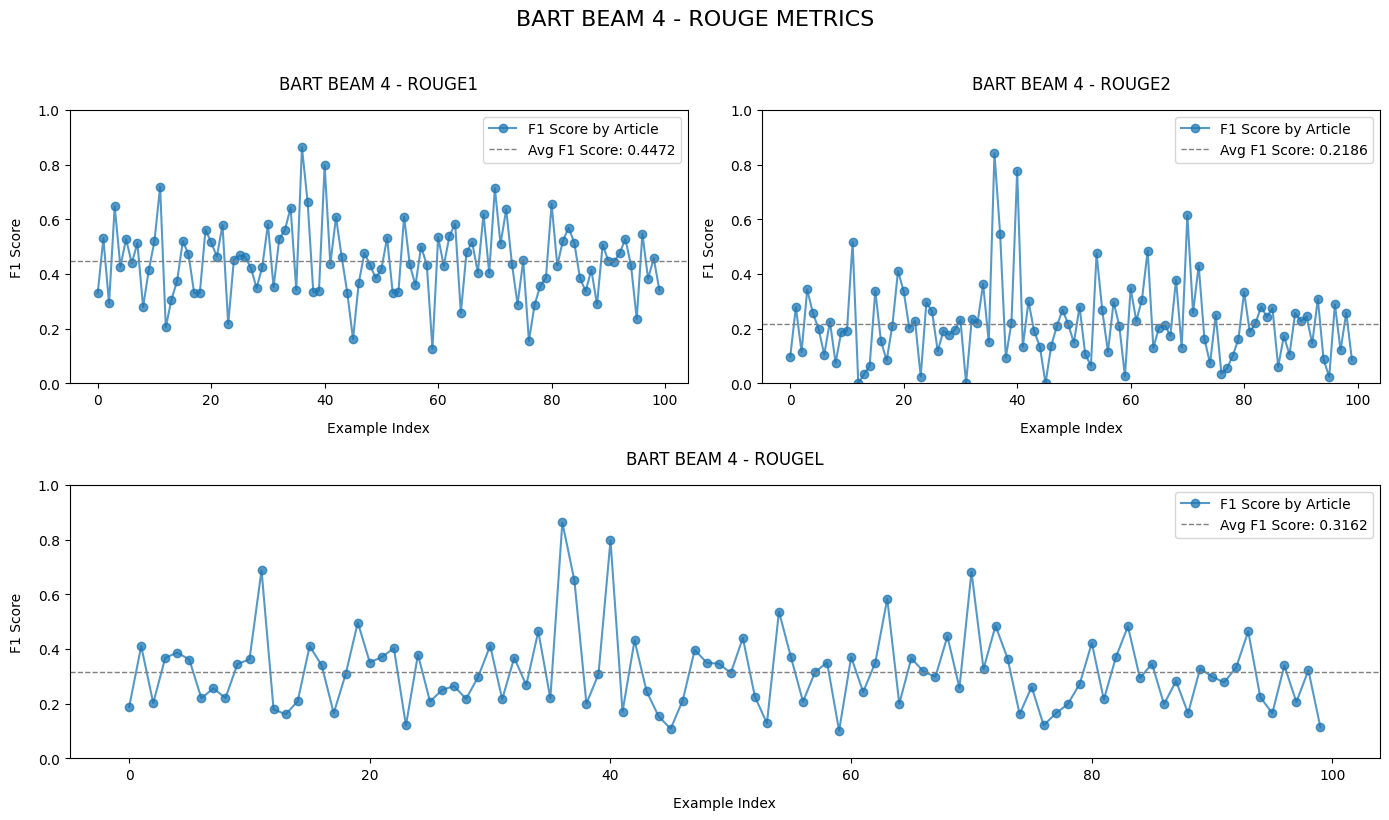

Evaluating: BART_BEAM_16...

Generating summaries for 100 articles...

Completed in 00:19:8.10


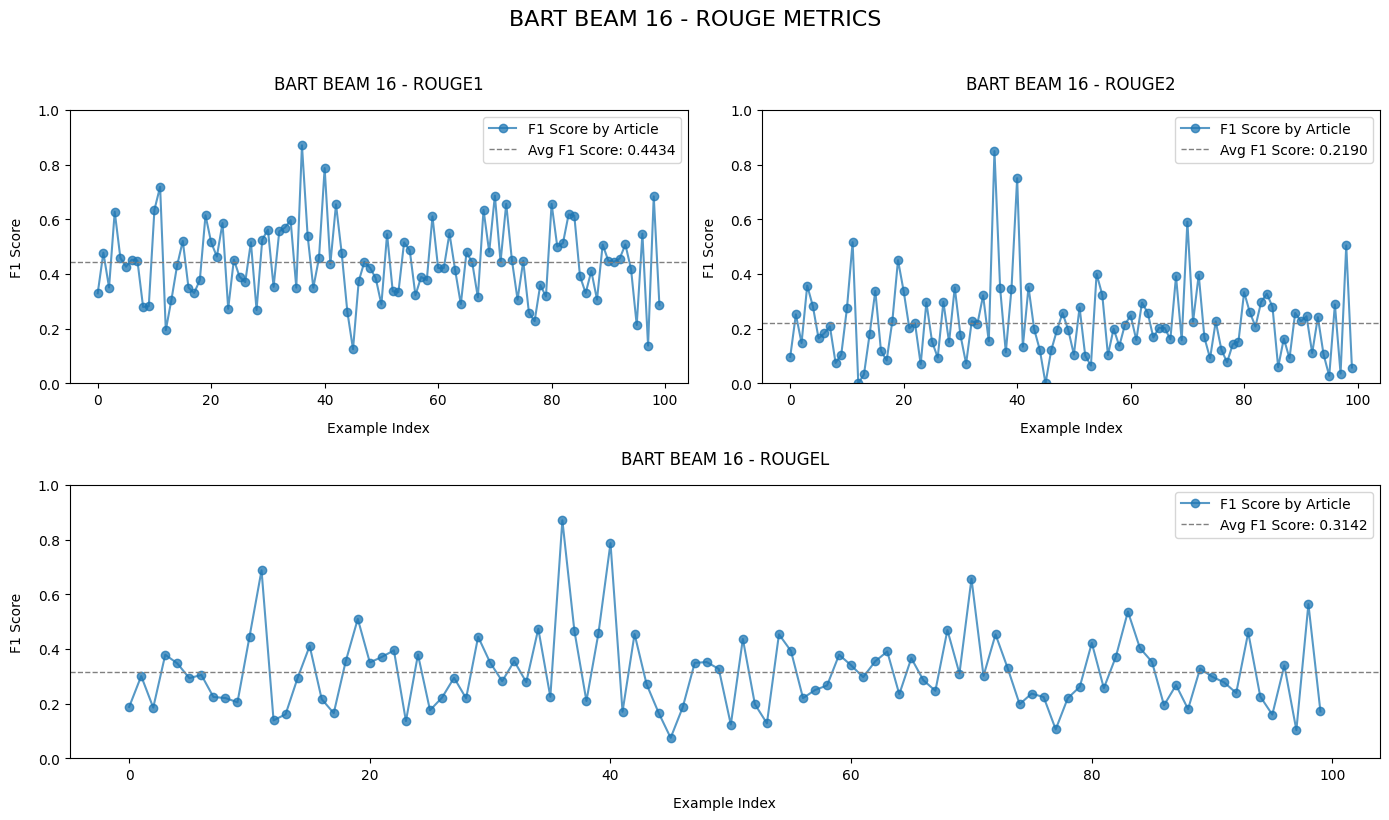

Evaluating: BART_LEN_PEN_08...

Generating summaries for 100 articles...

Completed in 00:11:29.00


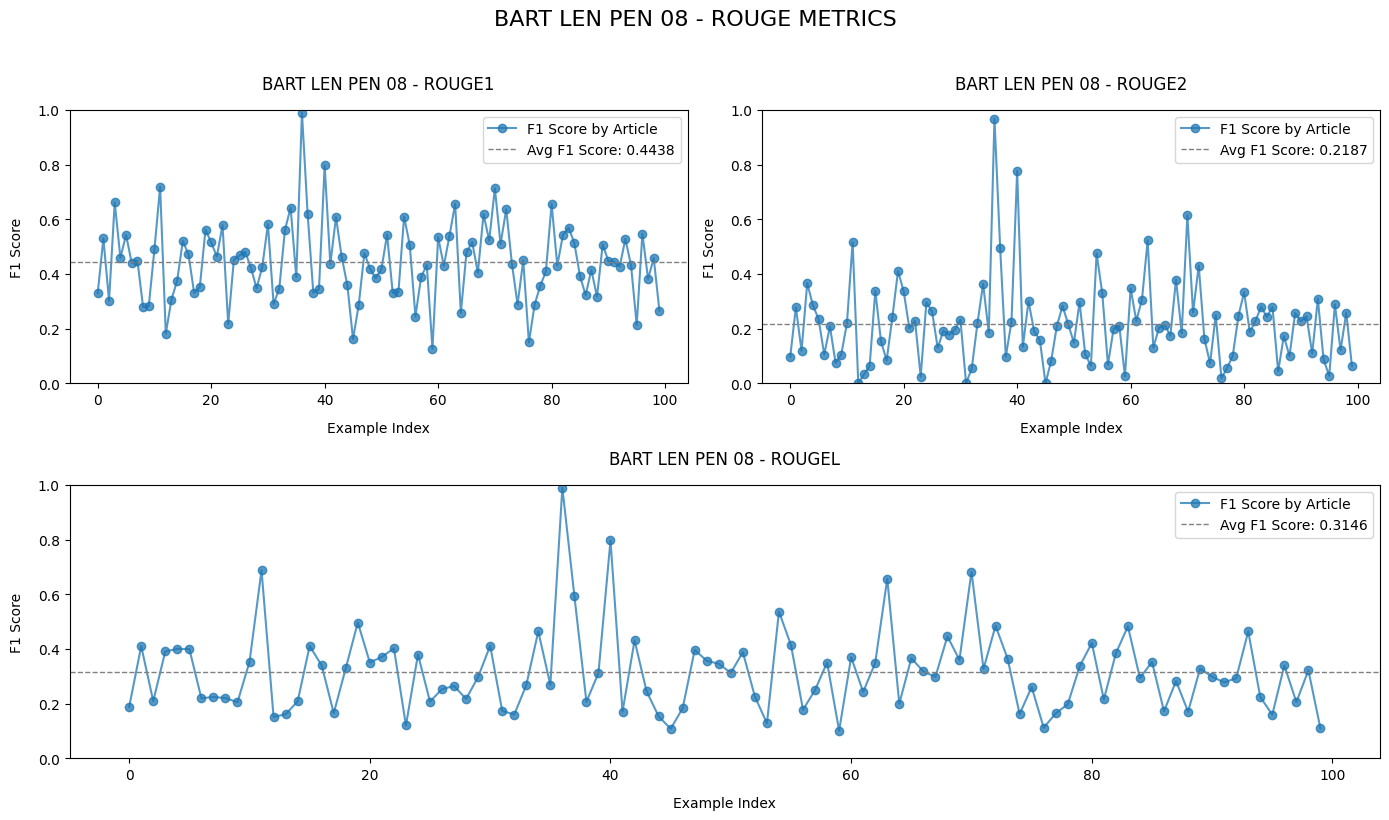

Evaluating: BART_LEN_PEN_12...

Generating summaries for 100 articles...

Completed in 00:11:31.66


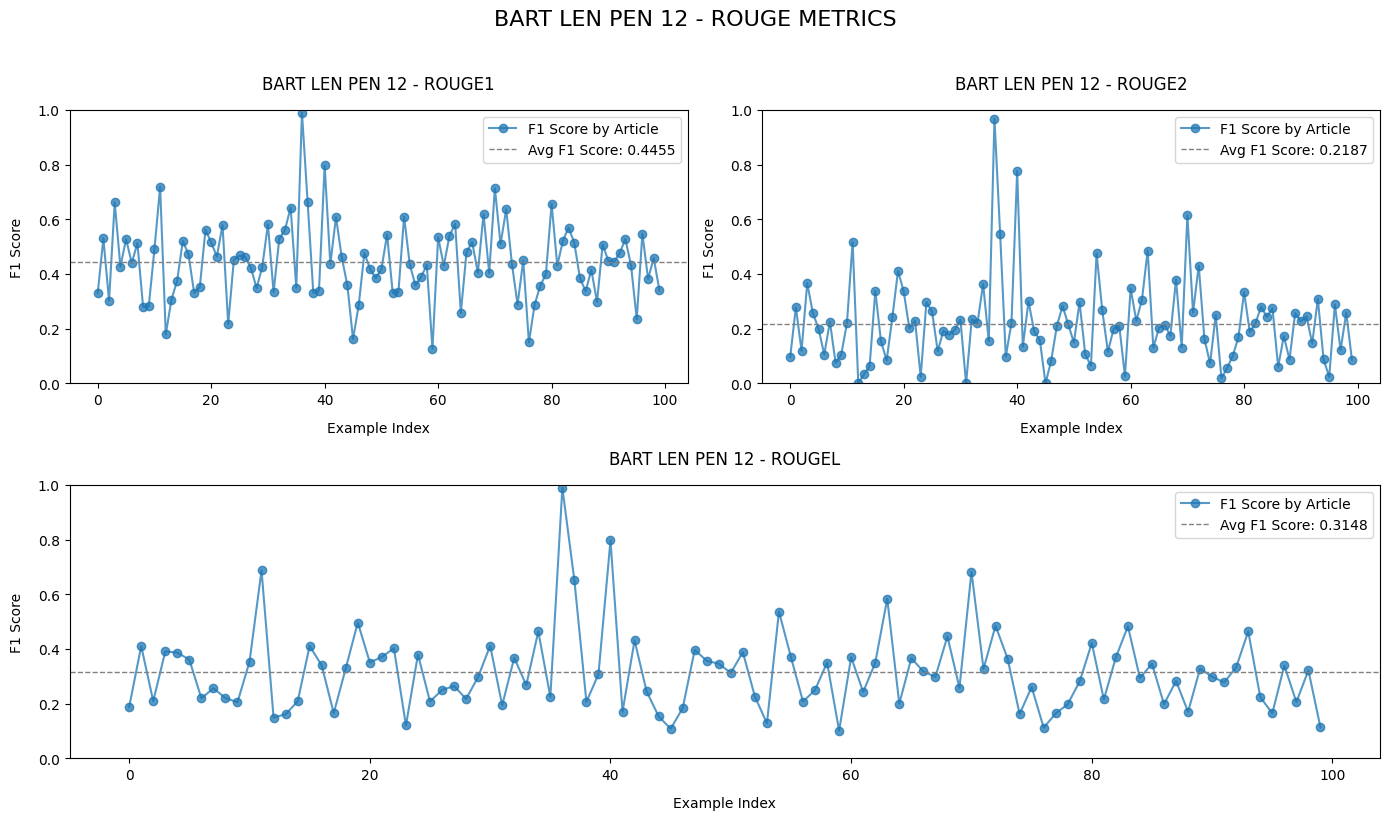

Evaluating: BART_NR_3GRAM...

Generating summaries for 100 articles...

Completed in 00:11:36.58


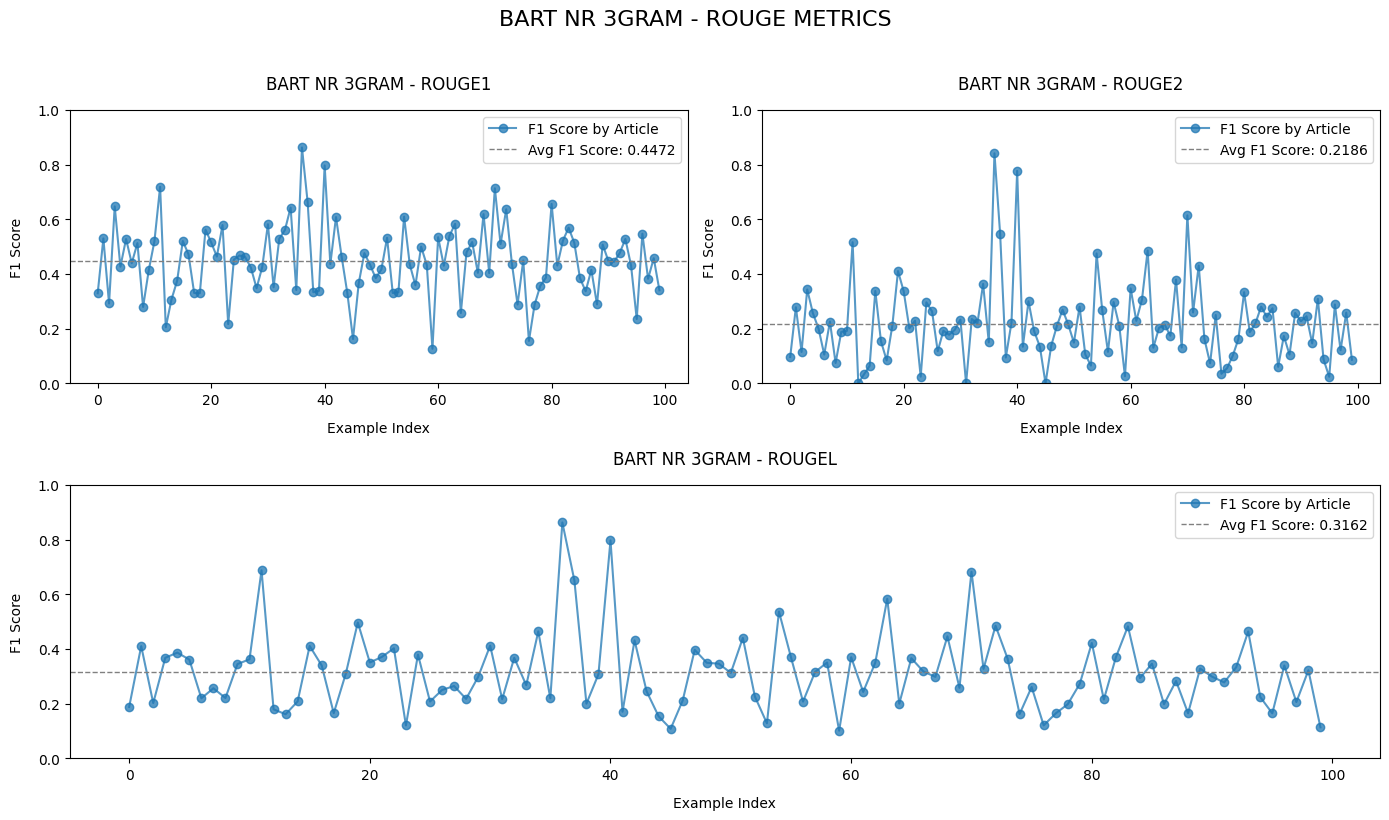

Evaluating: BART_SAMPLE_LOWP...

Generating summaries for 100 articles...

Completed in 00:12:24.85


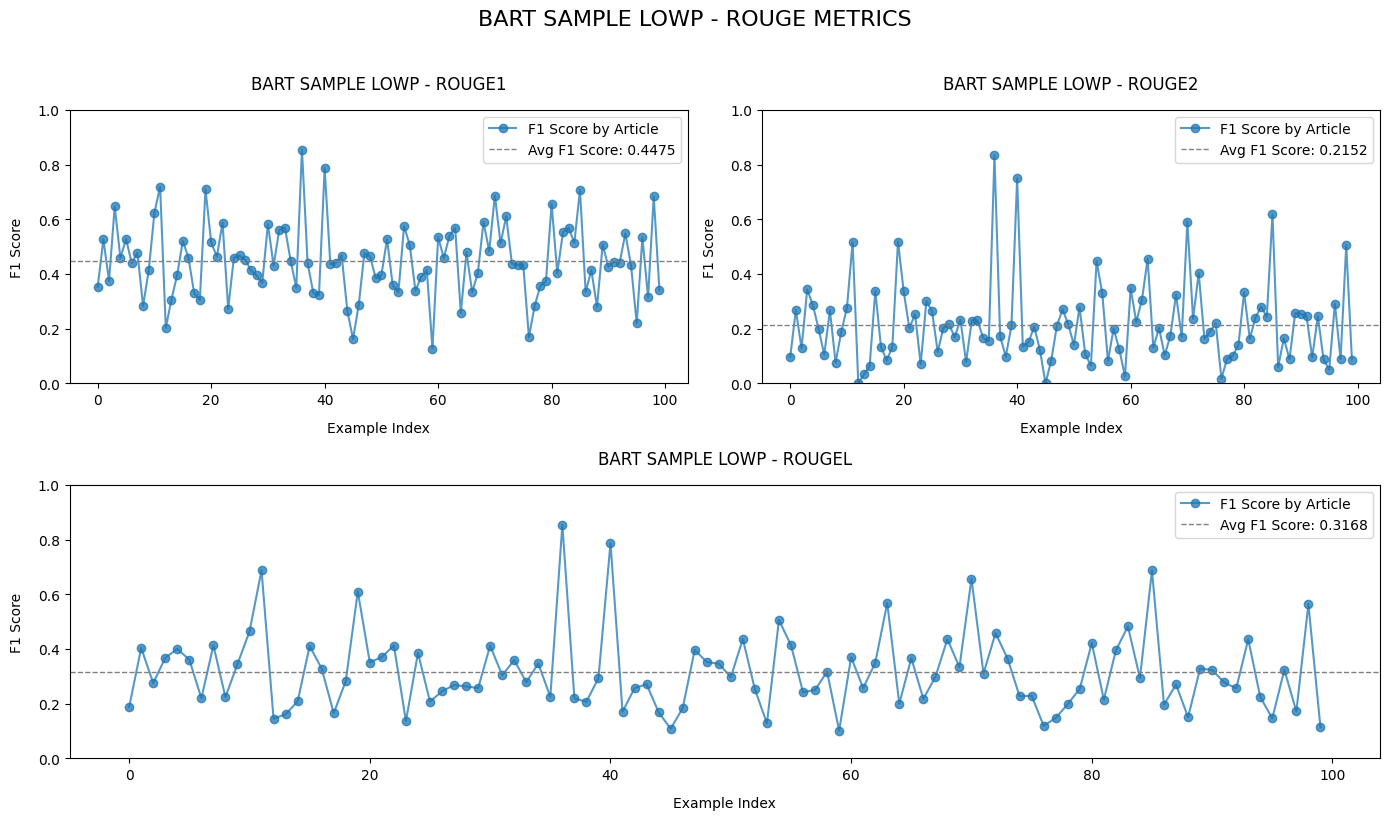

Evaluating: BART_SAMPLE_HIGHP...

Generating summaries for 100 articles...

Completed in 00:16:29.66


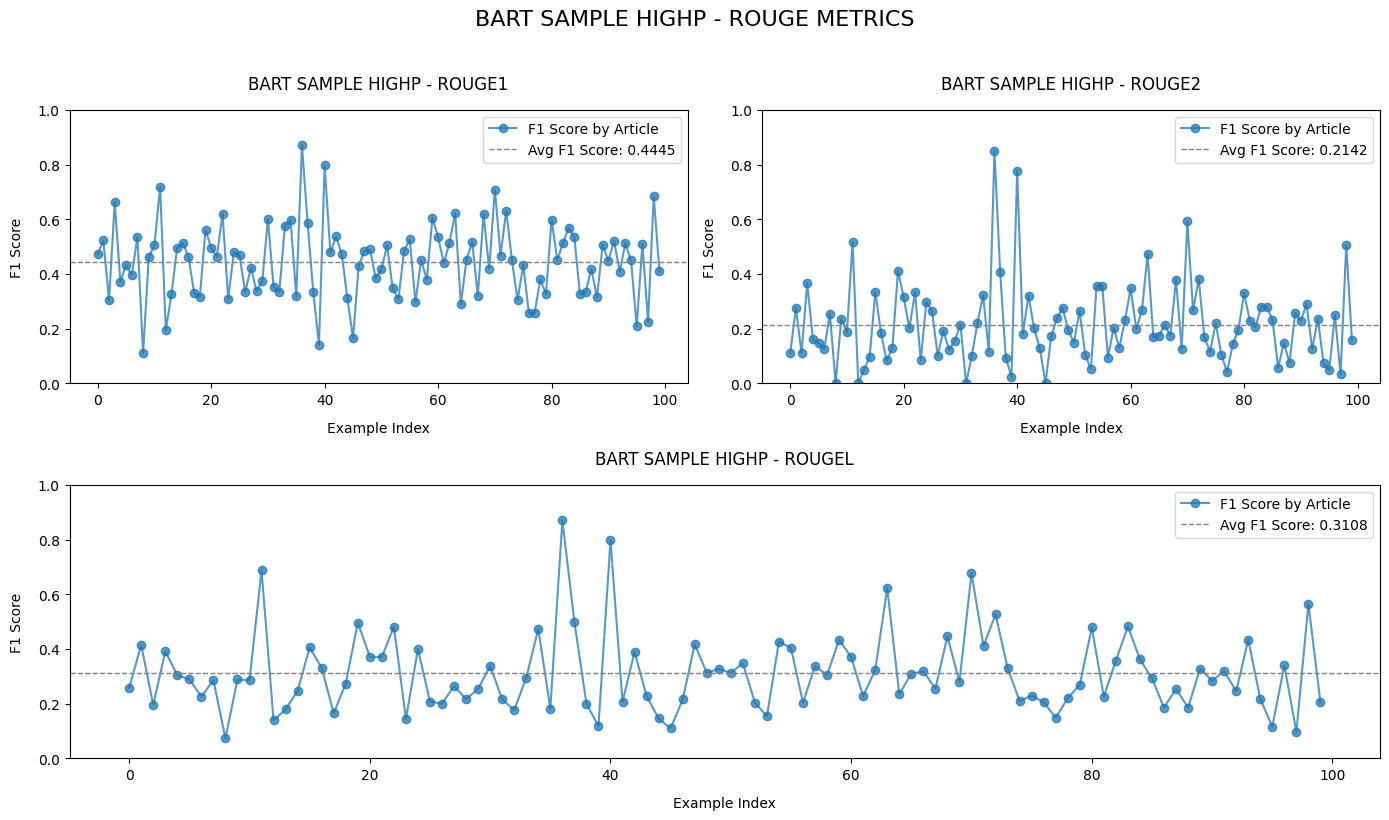

Evaluating: BART_SHORT...

Generating summaries for 100 articles...

Completed in 00:12:35.42


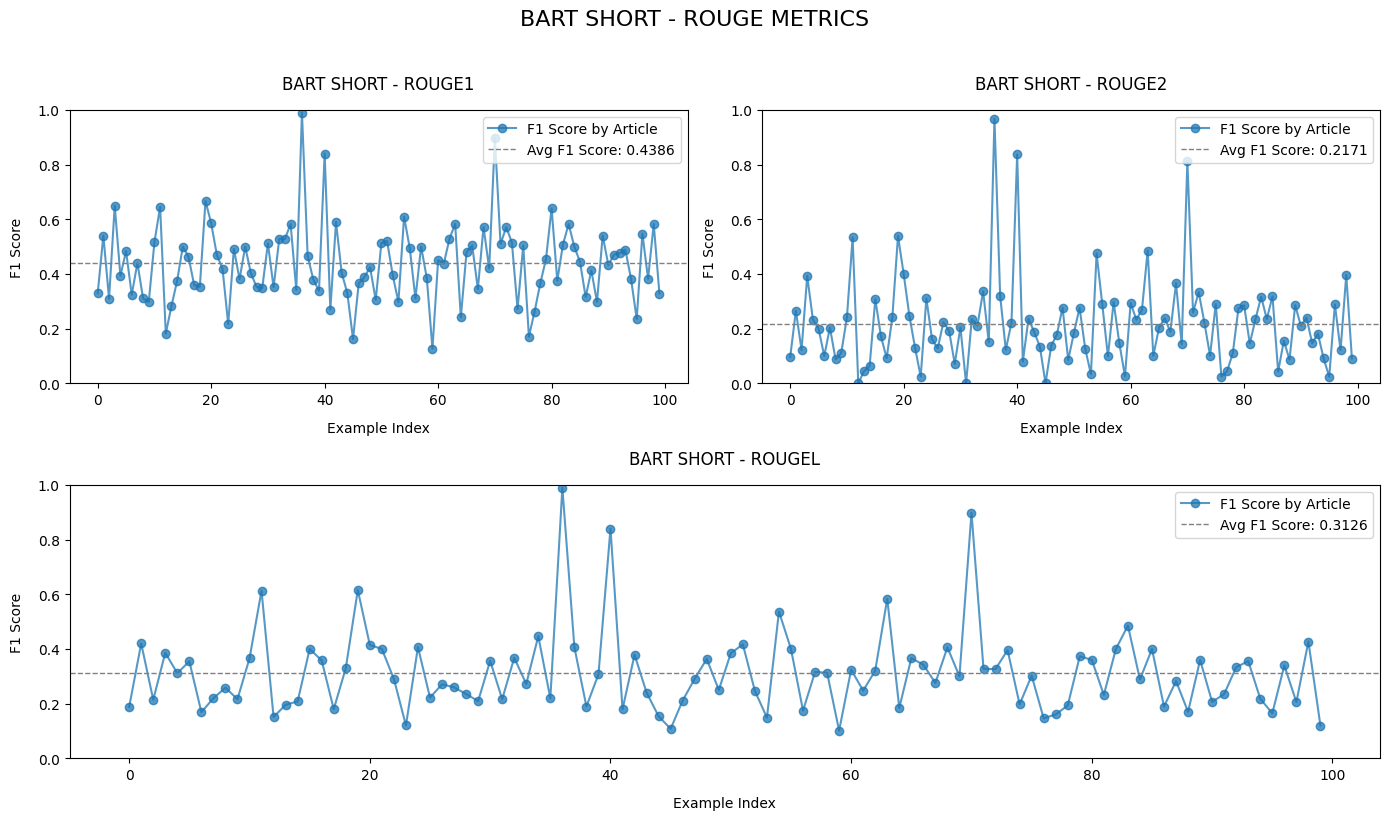

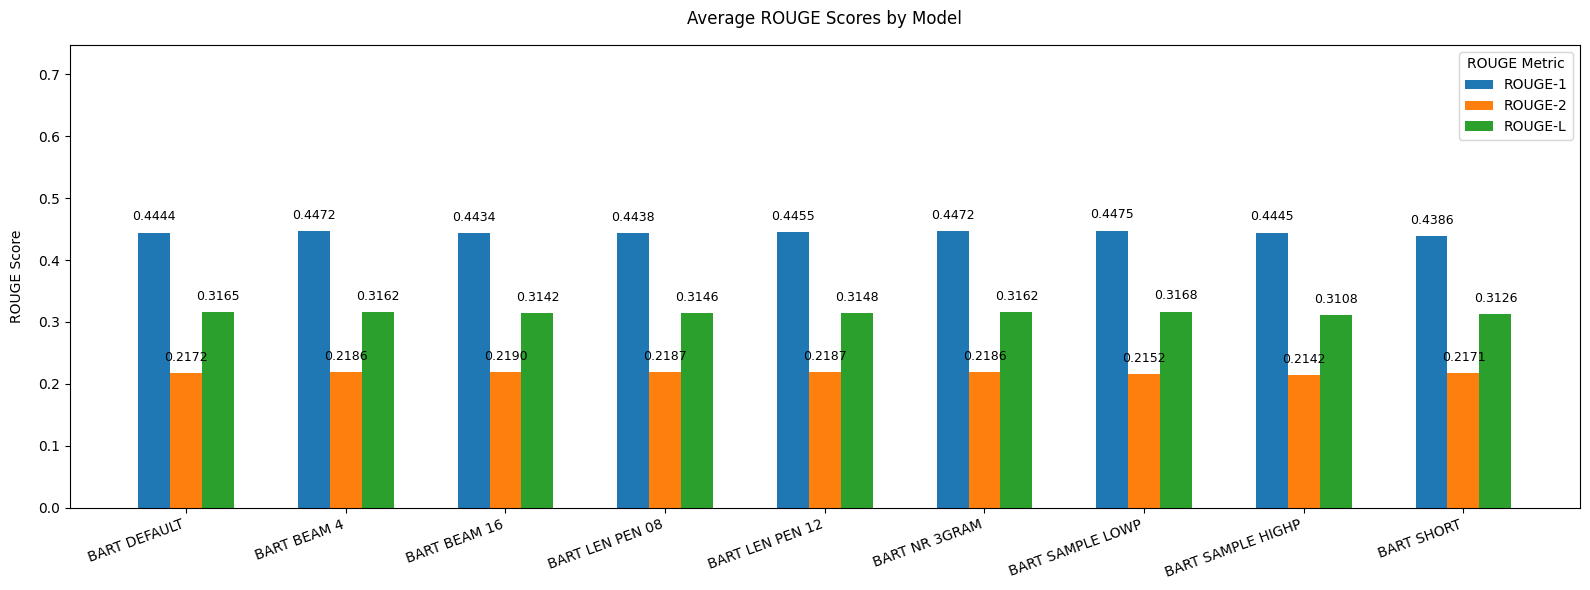

In [13]:
ablation_scores = sum_eval(articles, ablation_configs)
df_ablation = pd.DataFrame(ablation_scores).T.sort_values(by='rougeL', ascending=False)
plot_avg_rouge(ablation_scores, save_path=os.path.join(results_dir, 'ablation_avg_rouge_scores'))

#### Manual Evaluation



In [14]:
# Select 3 random articles
NUM_RANDOM_SAMPLES = 3
manual_ablation_articles = sample(test_corpus, NUM_RANDOM_SAMPLES)

##### BART DEFAULT

In [15]:
bart_default_summarizer = ablation_configs['bart_default']
bart_default_summaries = bart_default_summarizer.structured_batch_summarize(manual_ablation_articles)

The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Generating summaries for 3 articles...



The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['early_stopping', 'length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Completed in 00:00:9.58


In [16]:
# Evaluate Bart Default
bart_default_evaluator = ExtrinsicEvaluator(bart_default_summaries)
bart_default_evaluator.evaluate('BART DEFAULT')
bart_default_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_default_evaluator.submit_scores(bart_default_id_to_score)

Manually evaluating BART DEFAULT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fail

##### BART BEAM 4

In [17]:
# Generate Summaries
bart_beam_4_summarizer = ablation_configs['bart_beam_4']
bart_beam_4_summaries = bart_beam_4_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:25.11


In [18]:
# Evaluate Bart Beam 4
bart_beam_4_evaluator = ExtrinsicEvaluator(bart_beam_4_summaries)
bart_beam_4_evaluator.evaluate('BART BEAM 4')
bart_beam_4_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_beam_4_evaluator.submit_scores(bart_beam_4_id_to_score)

Manually evaluating BART BEAM 4...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the faile

##### BART BEAM 16

In [19]:
# Generate Summaries
bart_beam_16_summarizer = ablation_configs['bart_beam_16']
bart_beam_16_summaries = bart_beam_16_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:57.57


In [20]:
# Evaluate Bart Beam
bart_beam_16_evaluator = ExtrinsicEvaluator(bart_beam_16_summaries)
bart_beam_16_evaluator.evaluate('BART BEAM 16')
bart_beam_16_id_to_score = {  # Summaries identical to bart beam light
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,  # Identical to bart beam light
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  # Identical to bart beam light
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  # Identical to bart beam light
} 
bart_beam_16_evaluator.submit_scores(bart_beam_16_id_to_score)

Manually evaluating BART BEAM 16...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the fail

##### BART LENGTH PENALTY 0.8

In [21]:
# Generate Summaries
bart_len_pen_08_summarizer = ablation_configs['bart_len_pen_08']
bart_len_pen_08_summaries = bart_len_pen_08_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:25.99


In [22]:
# Evaluate Bart Length Penalty 0.8
bart_len_pen_08_evaluator = ExtrinsicEvaluator(bart_len_pen_08_summaries)
bart_len_pen_08_evaluator.evaluate('BART LENGTH PENALTY 0.8')
bart_len_pen_08_id_to_score = {  # Identical summaries to bart beam light and bart beam
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_len_pen_08_evaluator.submit_scores(bart_len_pen_08_id_to_score)

Manually evaluating BART LENGTH PENALTY 0.8...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, includi

##### BART LENGTH PENALTY 1.2

In [23]:
# Generate Summaries
bart_len_pen_12_summarizer = ablation_configs['bart_len_pen_12']
bart_len_pen_12_summaries = bart_len_pen_12_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:27.08


In [24]:
# Evaluate Bart Length Penalty 1.2
bart_len_pen_12_evaluator = ExtrinsicEvaluator(bart_len_pen_12_summaries)
bart_len_pen_12_evaluator.evaluate('BART LENGTH PENALTY 1.2')
bart_len_pen_12_id_to_score = {  
    "82d9d60e0360159b6767e0921de88360a93da0f5": 5,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5
}
bart_len_pen_12_evaluator.submit_scores(bart_len_pen_12_id_to_score)

Manually evaluating BART LENGTH PENALTY 1.2...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, includi

##### BART NO-REP 3GRAM

In [25]:
# Generate Summaries
bart_nr_3gram_summarizer = ablation_configs['bart_nr_3gram']
bart_nr_3gram_summaries = bart_nr_3gram_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:26.55


In [26]:
# Evaluate BART NO-REP 3GRAM

bart_nr_3gram_evaluator = ExtrinsicEvaluator(bart_nr_3gram_summaries)
bart_nr_3gram_evaluator.evaluate('BART NO-REP 3GRAM')
bart_nr_3gram_id_to_score = { 
    "82d9d60e0360159b6767e0921de88360a93da0f5": 4,  
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 4,  
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4   
}
bart_nr_3gram_evaluator.submit_scores(bart_nr_3gram_id_to_score)

Manually evaluating BART NO-REP 3GRAM...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the

##### BART SAMPLE LOWP

In [27]:
# Generate Summaries
bart_sample_lowp_summarizer = ablation_configs['bart_sample_lowp']
bart_sample_lowp_summaries = bart_sample_lowp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:27.84


In [28]:
# Evaluate BART SAMPLE LOWP
bart_sample_lowp_evaluator = ExtrinsicEvaluator(bart_sample_lowp_summaries)
bart_sample_lowp_evaluator.evaluate('BART SAMPLE LOWP')
bart_sample_lowp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 3,  
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4  
}
bart_sample_lowp_evaluator.submit_scores(bart_sample_lowp_id_to_score)

Manually evaluating BART SAMPLE LOWP...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the 

##### BART SAMPLE HIGHP

In [29]:
# Generate Summaries
bart_sample_highp_summarizer = ablation_configs['bart_sample_highp']
bart_sample_highp_summaries = bart_sample_highp_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:28.06


In [30]:
# Evaluate BART SAMPLE HIGHP
bart_sample_highp_evaluator = ExtrinsicEvaluator(bart_sample_highp_summaries)
bart_sample_highp_evaluator.evaluate('BART SAMPLE HIGHP')
bart_sample_highp_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,  
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,  
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 5  
}
bart_sample_highp_evaluator.submit_scores(bart_sample_highp_id_to_score)

Manually evaluating BART SAMPLE HIGHP...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the

##### BART SHORT

In [31]:
# Generate Summaries
bart_short_summarizer = ablation_configs['bart_short']
bart_short_summaries = bart_short_summarizer.structured_batch_summarize(manual_ablation_articles)

Generating summaries for 3 articles...

Completed in 00:00:20.44


In [32]:
# Evaluate BART SHORT
bart_short_evaluator = ExtrinsicEvaluator(bart_short_summaries)
bart_short_evaluator.evaluate('BART SHORT')
bart_short_id_to_score = {
    "82d9d60e0360159b6767e0921de88360a93da0f5": 3,
    "5590b3cff374d453e9bc46e93ea8f90ce94e6c1b": 5,
    "a502426e1671ae4e72690da82f5f2bc9bc589e20": 4
}
bart_short_evaluator.submit_scores(bart_short_id_to_score)

# Strong performance with some smaller details missing

Manually evaluating BART SHORT...
ID: 406da8a5e3a90d4f91ba45689df958ea44b2e430
Article:
Two hitmen associates of a ‘Freddy Krueger’ killer who tried to gun down a rival during London’s bloodiest gang feud have been jailed for a total of 44 years today. Christopher Annan, 24, and Tyrone Wright, 20, took part in a gun attack on Tottenham Turks gang member Inan Eren. The 35-year-old victim, who survived, was ambushed as he arrived home on the evening of 30 December 2012, shot three times in the arm, stomach and buttock. The attack was led by hitman Jamie Marsh-Smith, 23, a fearsome hired gun who had earned the nickname ‘Freddy’ after the Nightmare on Elm Street killer. Jamie Marsh-Smith (left) known as 'Freddy' after the Nightmare on Elm Street character, executed gang boss Zafer Eren (right). He also took part in the attack on Eren's cousin Inan for which two men were jailed today . The deranged Freddy Krueger. Marsh-Smith got his nickname carrying out contract hits, including the failed

## Manual Evaluation Results

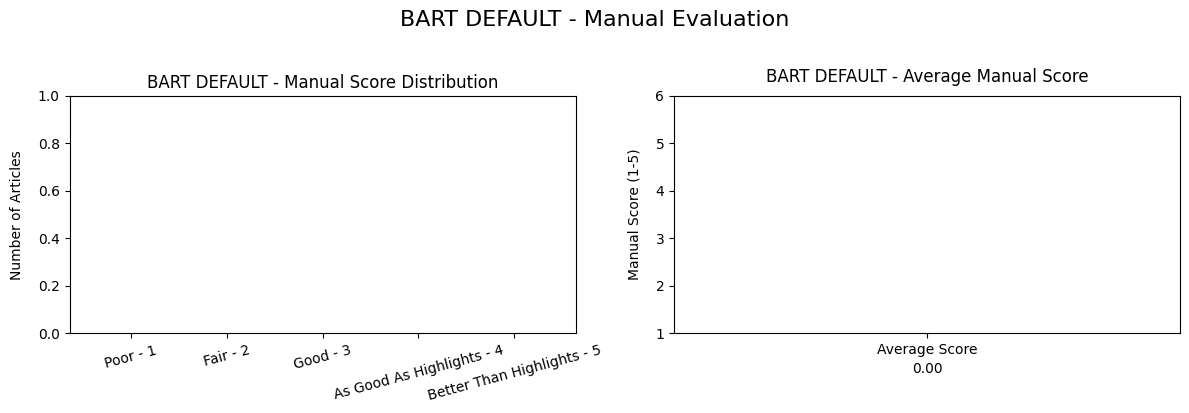

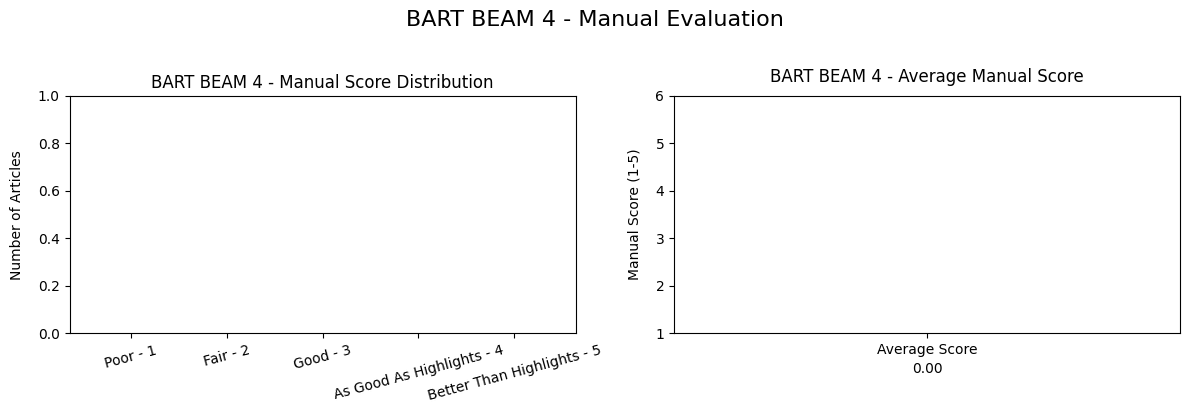

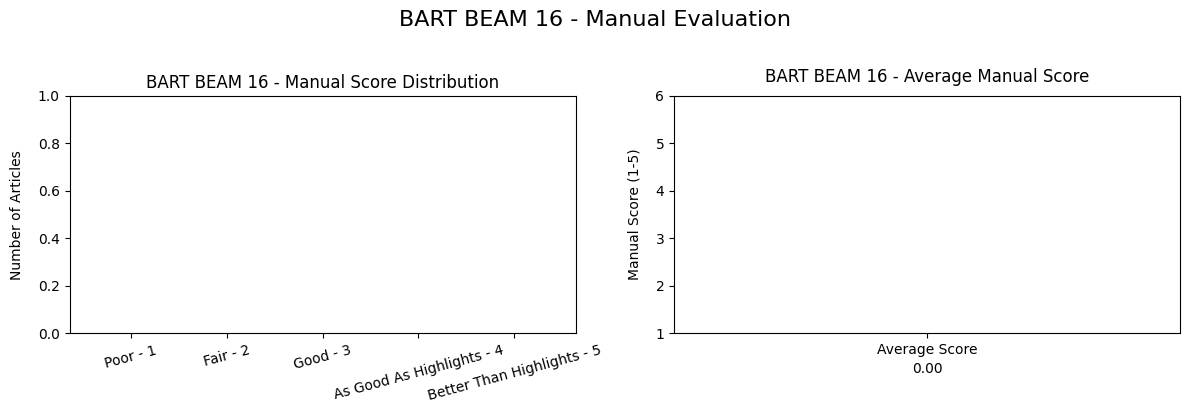

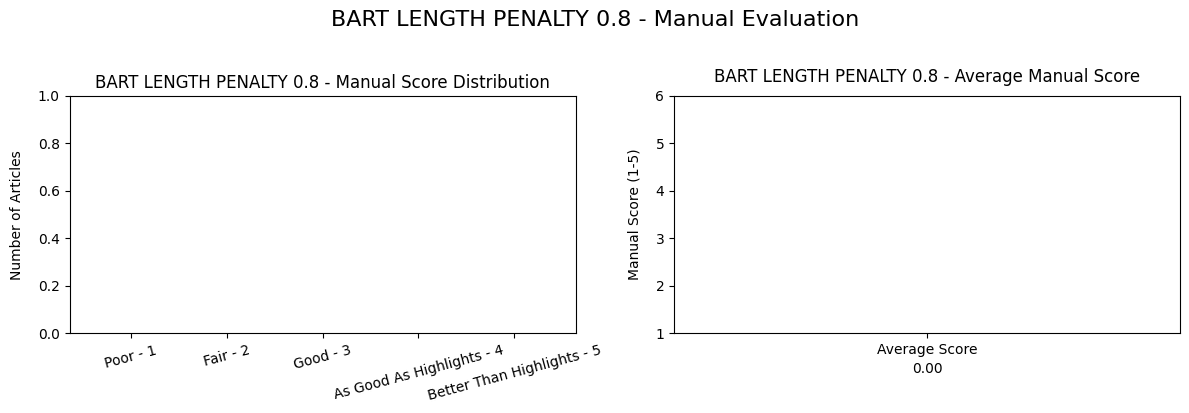

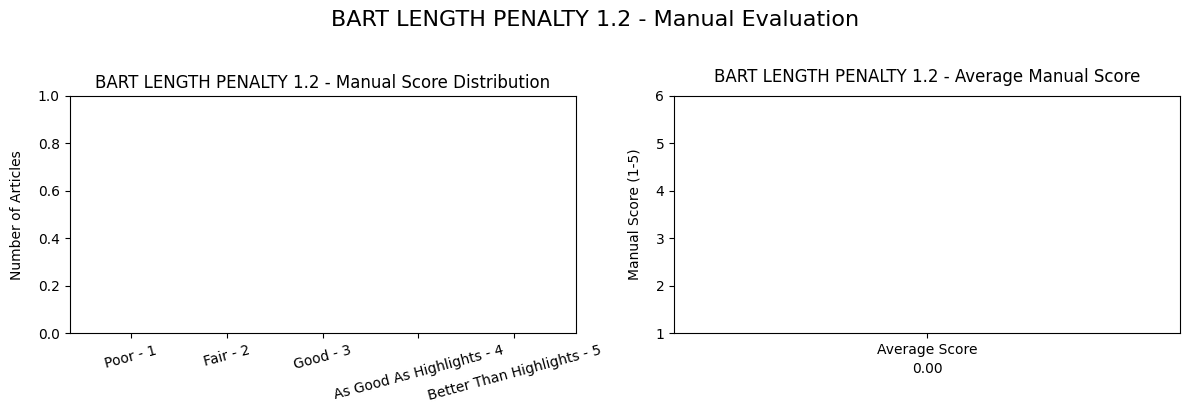

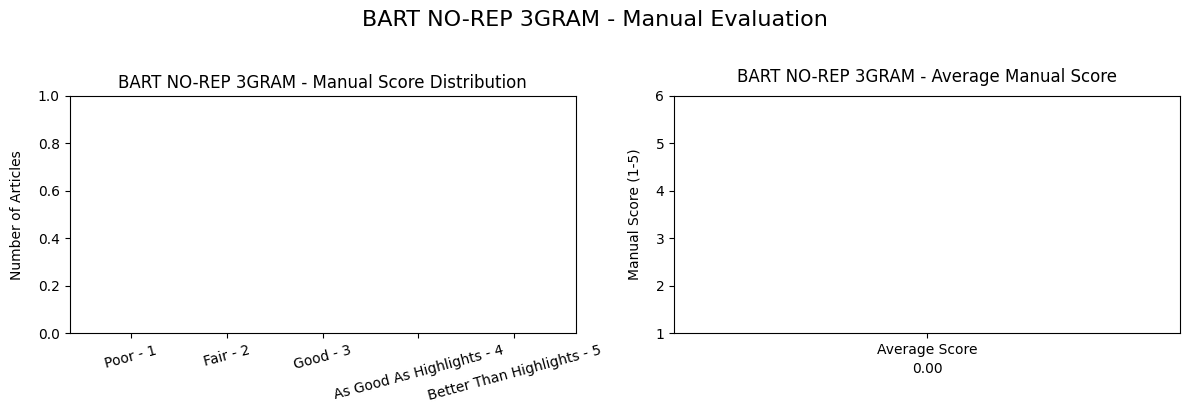

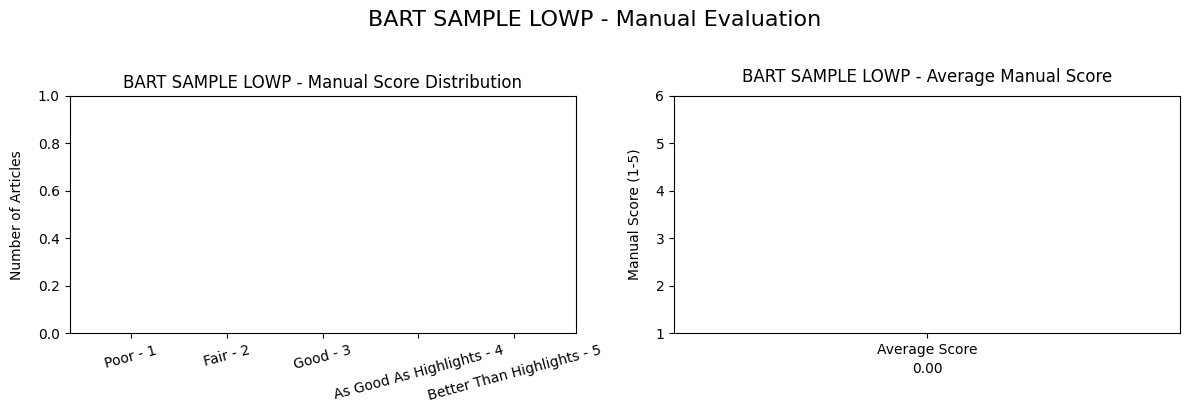

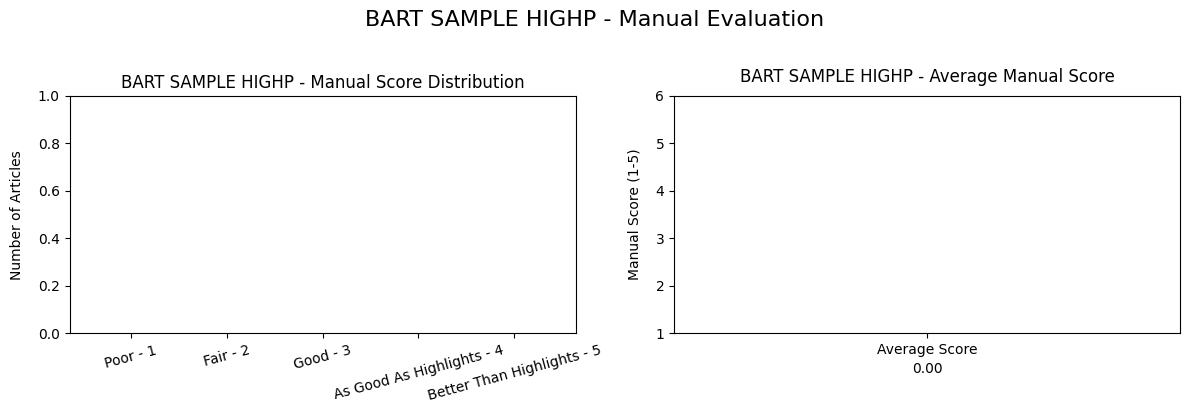

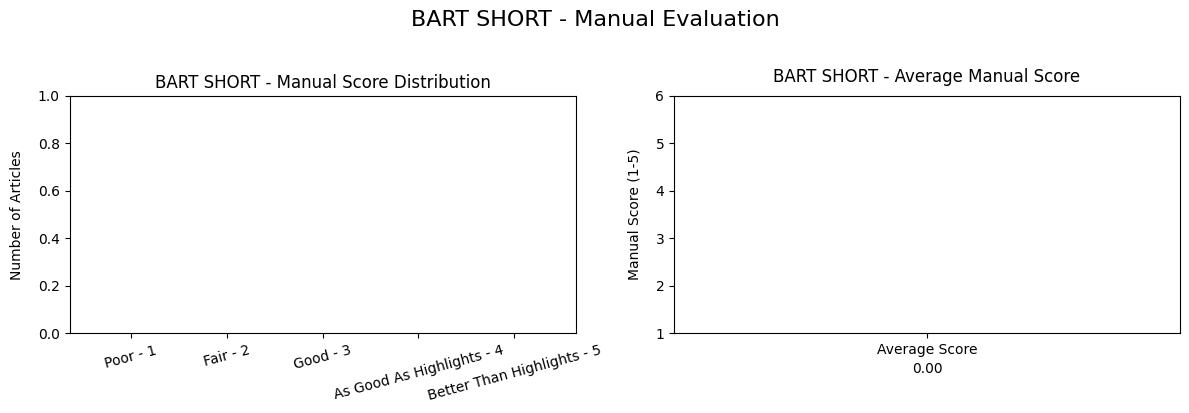

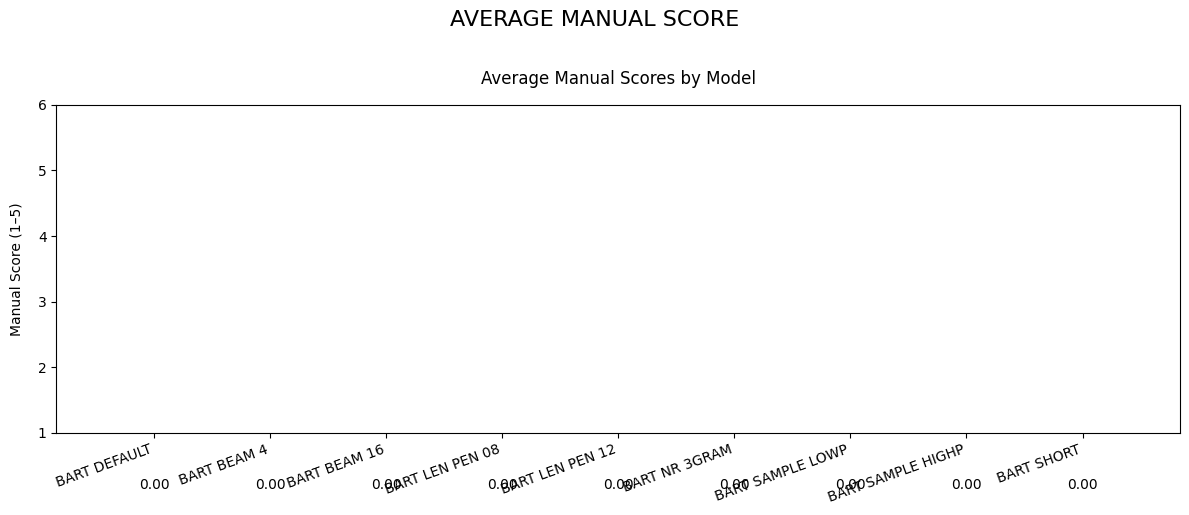

In [33]:
# Plot ablation models
bart_default_evaluator.plot('BART DEFAULT', save_path=os.path.join(results_dir, 'bart_default'))
bart_beam_4_evaluator.plot('BART BEAM 4', save_path=os.path.join(results_dir, 'bart_beam_4'))
bart_beam_16_evaluator.plot('BART BEAM 16', save_path=os.path.join(results_dir, 'bart_beam_16'))
bart_len_pen_08_evaluator.plot('BART LENGTH PENALTY 0.8', save_path=os.path.join(results_dir, 'bart_len_pen_08'))
bart_len_pen_12_evaluator.plot('BART LENGTH PENALTY 1.2', save_path=os.path.join(results_dir, 'bart_len_pen_12'))
bart_nr_3gram_evaluator.plot('BART NO-REP 3GRAM', save_path=os.path.join(results_dir, 'bart_nr_3gram'))
bart_sample_lowp_evaluator.plot('BART SAMPLE LOWP', save_path=os.path.join(results_dir, 'bart_sample_lowp'))
bart_sample_highp_evaluator.plot('BART SAMPLE HIGHP', save_path=os.path.join(results_dir, 'bart_sample_highp'))
bart_short_evaluator.plot('BART SHORT', save_path=os.path.join(results_dir, 'bart_short'))

ablation_avg_manual_scores = {
    'bart_default': bart_default_evaluator.avg_score,
    'bart_beam_4': bart_beam_4_evaluator.avg_score,
    'bart_beam_16': bart_beam_16_evaluator.avg_score,
    'bart_len_pen_08': bart_len_pen_08_evaluator.avg_score,
    'bart_len_pen_12': bart_len_pen_12_evaluator.avg_score,
    'bart_nr_3gram': bart_nr_3gram_evaluator.avg_score,
    'bart_sample_lowp': bart_sample_lowp_evaluator.avg_score,
    'bart_sample_highp': bart_sample_highp_evaluator.avg_score,
    'bart_short': bart_short_evaluator.avg_score,
}

plot_avg_manual_score(ablation_avg_manual_scores, save_path=os.path.join(results_dir, 'ablation_avg_manual_scores'))